## Question 1
On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis.

### a. Think about what could be going wrong with our calculation. Think about a better way to evaluate this data.

In [146]:
import numpy as np
from numpy import *
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random
import math


In [147]:
data = read_csv('/Users/michelle/Downloads/Challenge_Data_Set.csv')


In [148]:
data['order_amount'].describe()


count      5000.000000
mean       3145.128000
std       41282.539349
min          90.000000
25%         163.000000
50%         284.000000
75%         390.000000
max      704000.000000
Name: order_amount, dtype: float64

I'm interested in where that AOV of 3145.13 came from. After I use panda's describe() method on the data frame, we can see that the mean order amount is indeed 3,145.13. However, there is an incredibly large standard deviation of 41282.54. This means that on average, the values vary 41,282.54 from the mean, making the mean not a very useful representation of the AOV.

We can see the minimum value is 90 and max value is 704,000 and we can also see the values for the median and first and third quartile. Comparing these numbers, we can see that the maximum value is much higher than the other values. Considering our dataset has 5000 records, there are probably a few outlier values that are incredibly high dragging up the mean.

To validate our guessing, we can draw a boxplot and distribution plot.

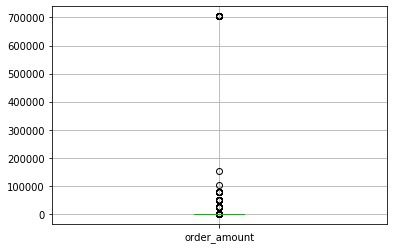

In [153]:
data.boxplot(column='order_amount')


From the boxplot, we can see that the entire box portion of the box plot is a line along 0! It looks like there are lots of outliers. 

From the distribution plot, we can see that majority of value is below 200000, but there are few outliers beyond 600000.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8859219890>]],
      dtype=object)

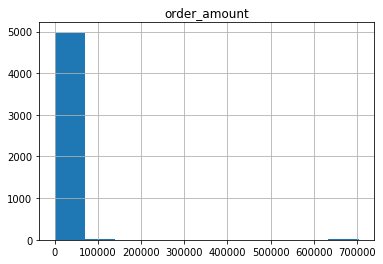

In [154]:
data.hist(column='order_amount')


In [160]:
unique_amounts = data.groupby(['order_amount']).size().reset_index(name='count').sort_values(by='order_amount', ascending=False)
unique_amounts.head(10)


,order_amount,count
257,704000,17
256,154350,1
255,102900,1
254,77175,9
253,51450,16
252,25725,19
251,1760,1
250,1408,2
249,1086,1
248,1064,1


 It looks like some of these high order amounts are repeated, especially 704000, 51450, and 25725. Let's look at these rows from our original dataset.

In [162]:
data.loc[data['order_amount'].isin([704000, 51450, 25725])].sort_values(by='order_amount', ascending=False)



,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
15,16,42,607,704000,2000,credit_card,2017-03-07 4:00:00
1362,1363,42,607,704000,2000,credit_card,2017-03-15 4:00:00
2969,2970,42,607,704000,2000,credit_card,2017-03-28 4:00:00
2835,2836,42,607,704000,2000,credit_card,2017-03-28 4:00:00
4056,4057,42,607,704000,2000,credit_card,2017-03-28 4:00:00
60,61,42,607,704000,2000,credit_card,2017-03-04 4:00:00
2297,2298,42,607,704000,2000,credit_card,2017-03-07 4:00:00
2153,2154,42,607,704000,2000,credit_card,2017-03-12 4:00:00
1562,1563,42,607,704000,2000,credit_card,2017-03-19 4:00:00
1436,1437,42,607,704000,2000,credit_card,2017-03-11 4:00:00


 It appears the order amounts of 704000 occur at the same time each day between the same store and users. The data for order amounts of 51450 and 25725 similar. It appears as though orders of 51450 are just transactions that bought two items worth 25725 as they all come from the same store id 78.

For the 704000 amounts, it seems like the transactions are probably some sort of supplier purchasing many shoes at once since the order amount is consistently 2000.

To better evaluate this data, we can clean some of the values. Let's try plotting only values that are the median +/- 1.5 times the interquartile range.Thus is, I want to remove the outliers since there are some abnormal patterns in these values.Then I replot the boxplot of the new truncated dataset.

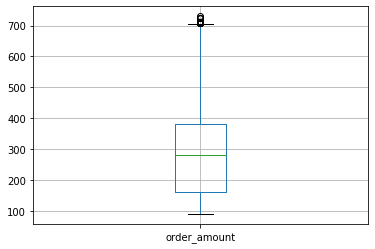

In [169]:
q1 = data.order_amount.quantile(q = 0.25)
q2 = data.order_amount.quantile(q= 0.5)
q3 = data.order_amount.quantile(q = 0.75)
IQR = q3- q1
data_truancted = data[(data.order_amount <= q3 + IQR * 1.5 ) & (data.order_amount >= q1 - 1.5 * IQR )]
data_truancted.boxplot(column = 'order_amount')

Now we can see that the boxplot looks much better!

###  b. What metric would you report for this dataset?

### Method 1:
After removing the outliers and looking at the box plot for data_truancted, it looks like the distribution is skewed towards lower values. With this in mind, I would report the median value of the truncated dataset. The values above the median will increase the  the mean a disproportionate amount.

### Method 2:
Since the range between the max and min are large, I will use machine learning method clustering to rank the dataset into high and low order amount group. 

In [172]:
# calculate Euclidean distance
def euclDistance(x, y):
    return sqrt(sum(power(x - y, 2)))
 

In [184]:
dataSet = np.array(data['order_amount'])
k = 2
numSamples = dataSet.shape[0]
    # first column stores which cluster this sample belongs to,
    # second column stores the error between this sample and its centroid
clusterAssment = mat(zeros((numSamples, 2)))
clusterChanged = True
L_list = []

## step 1: init centroids
centroids = np.random.randn(k)

for iter in range(0,20):
        ## for each sample
        for i in xrange(numSamples):
            minDist  = 100000.0
            minIndex = 0
            ## for each centroid
            ## step 2: find the centroid who is closest
            for j in range(k):
                distance = euclDistance(centroids[j], dataSet[i])
                if distance < minDist:
                    minDist  = distance
                    minIndex = j

            ## step 3: update its cluster
            if clusterAssment[i, 0] != minIndex:
                clusterAssment[i, :] = minIndex, minDist**2
        ## step 4: update centroids
        L = 0
        for j in range(k):
            pointsInCluster = dataSet[nonzero(clusterAssment[:, 0].A == j)[0]]
            centroids[j] = mean(pointsInCluster, axis = 0)

            for t in range(pointsInCluster.shape[0]):
                dist_x_c = dis(centroids[j],pointsInCluster[t])
                L += dist_x_c 
                L_list.append(L)
    
                


In [144]:
centroids

array([643434.21052632,    702.74844409])

We can used centroids as a matrix to group our shoes into high order amount shoes or low order amount shoes. When the amount is around 643434, it is high order amount shoe. Instead, when the order amount is around 702.7, it can be grouped into low order amount shoe.

## Question 2

For this question you’ll need to use SQL. Follow this link to access the data set required for the challenge. Please use queries to answer the following questions. Paste your queries along with your final numerical answers belo

### a. How many orders were shipped by Speedy Express in total?

Ans:54.
If we join the [Orders] and [Shippers] tables on ShipperID, we can filter table by orders performed by Speedy Express and count the entries.

~~~~sql
SELECT COUNT(DISTINCT OrderID) AS total_order
FROM Orders o
LEFT JOIN Shippers s
ON o.shipperID = s.shipperID
WHERE s.Shippername = 'Speedy Express';
~~~~

### b. What is the last name of the employee with the most orders?

Ans:The last name of the employee with the most orders is Peacock and it had most orders at 40.

With SQL, we could count the number of orders in [Orders] and group by EmployeeID. This would give us which employee ID has the most orders, but not that employee's last name. Instead, we can use the JOIN expression to merge the [Orders] table and the [Employees] to match the employees to their employee ID and group by their last name to solve the problem.

~~~~sql
SELECT a.EmployeeID, b.Lastname
FROM
(SELECT EmployeeID, count(OrderID) AS num_of_order
FROM [Orders]
GROUP BY EmployeeID
ORDER BY num_of_order DESC 
LIMIT 1) a
LEFT JOIN Employees b
on a.EmployeeID = b.EmployeeID;
~~~~

#### c.What product was ordered the most by customers in Germany?


Ans:Product Boston Crab Meat with productID 40 was ordered the most by customers in Germany and the total order number is 160.




~~~~sql
SELECT b.ProductID, c.ProductName, SUM(b.Quantity) AS num_of_product
FROM [Orders] a
LEFT JOIN OrderDetails b
ON a.OrderID = b.OrderID
LEFT JOIN Products c
ON b.ProductID = c.ProductID
WHERE a.customerID IN 
(SELECT CustomerID FROM Customers
WHERE country = 'Germany')
GROUP BY b.ProductID
ORDER BY num_of_product DESC;
~~~~